# Price_Indicator_Analysis

Analysis of common technical analysis indicators on daily price data for different products.

## Data Collection

In [1]:
import pandas as pd
import numpy as np

import requests
import json
import quandl

import datetime

import matplotlib.pyplot as plt
import seaborn as sns

import sqlite3

import re

% matplotlib inline
sns.set_style('whitegrid')
blues = sns.color_palette('Blues')

The first step will be to get data from the [quandl API](https://www.quandl.com/collections/futures).  For this we use an api key generated from signing up for a free quandl account.

We create a list of the symbols for the products we are interested in, which can be found by looking at the [documentation](https://docs.quandl.com/).

Then loop through the products, read the price data into a dataframe, and attach the symbol:dataframe key:value pair to a dictionary object, after selecting the specific information we need.

In [2]:
# Get data from Quandl with api key
api_key = 'Hv95pPh1xQWzt5DFhxS7'

# Create list of symbols for the products we want data for
prod_list = ['CL', 'HO', 'NG', 'GC',
             'SI', 'AD', 'CD', 'EC',
             'BP', 'JY', 'US', 'C',
             'W', 'S', 'ES']

# Create a dict with keys as symbols and values as dataframe of price info
prod_dict = {}

# Iterate through list of prods and add data to dict
for prod in prod_list:
    # Quandl API call
    df = quandl.get('SCF/CME_{p}1_FW'.format(p=prod), authtoken=api_key)
    
    # Drop open interest column and rename Settle column
    df.drop(['Prev. Day Open Interest'], axis=1, inplace=True)
    df.rename(columns={'Open': 'open',
                      'High': 'high',
                      'Low': 'low',
                      'Settle': 'close',
                      'Volume': 'volume'}, inplace=True)
    # Add prod to dict
    prod_dict[prod] = df

Here is some summary information of the Crude Oil ('CL') dataframe

In [6]:
cl = prod_dict['CL']
cl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2517 entries, 2005-01-03 to 2014-12-31
Data columns (total 5 columns):
open      2517 non-null float64
high      2517 non-null float64
low       2517 non-null float64
close     2517 non-null float64
volume    2517 non-null float64
dtypes: float64(5)
memory usage: 118.0 KB


In [4]:
cl.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2517.0,81.796207,19.832869,34.36,65.68,82.55,96.90,145.19
high,2517.0,82.893532,19.961713,36.25,66.56,83.72,97.82,147.27
low,2517.0,80.582003,19.695067,33.55,64.65,81.25,95.56,143.22
close,2517.0,81.779758,19.855341,33.98,65.82,82.55,96.92,145.29
volume,2517.0,241235.096146,96750.320207,50.00,175510.60,242868.00,301777.00,670082.00


In [5]:
cl.head()

,open,high,low,close,volume
Date,,,,,
2005-01-03,43.10,43.10,41.25,42.12,69484.0
2005-01-04,42.18,44.13,41.85,43.91,100665.0
2005-01-05,43.90,44.00,42.60,43.39,91011.0
2005-01-06,43.39,45.75,42.80,45.56,122411.0
2005-01-07,45.50,46.10,44.75,45.43,99725.0


Now we have the data from quandl broken down into specific products and we have the columns we are interested in as well as a datetime object as an index.  Next we will do the same thing with the data from the [Cryptocompare API](https://www.cryptocompare.com/api/).

First step here will be do define the url and parameters we need.  This information can be gathered by reading through the documentation.  

Again we need to create a list of symbol names to use as arguments when calling the API.

Then we do a `get` request using the `requests` library, loop through the symbols list and do some manipulation to the final dataframe.  

When this is all done we can just append the df to our prod_dict to put them all together.

In [3]:
# Cryptocompare API url
url = 'https://min-api.cryptocompare.com/data/histoday'

# List of cryptocurrencies to gather data for
symbol_list = ['BTC', 'ETH', 'XRP', 'LTC', 'XLM',
               'EOS', 'NEO', 'ADA', 'BCH', 'XMR']

# Iterate through the list to create a df for each symbol
for symbol in symbol_list:
    # Set relevant parameters, currency in USD and limit of 2000 data points
    params = {'fsym': symbol, 'tsym': 'USD', 'limit': 2000}
    
    # Call API and put data into a dataframe
    response = requests.get(url, params=params)
    data = response.json()['Data']
    df = pd.DataFrame(data)
    
    # Add date column and set to index
    df['Date'] = [datetime.date.fromtimestamp(d) for d in df.time]
    df = df[['open', 'high', 'low', 'close', 'volumeto', 'Date']]
    df.set_index('Date', inplace=True)
    
    # Rename volumeto column
    df.rename(columns={'volumeto': 'volume'}, inplace=True)
    
    # Append to prod_dict
    prod_dict[symbol] = df


Now all the products we are interested in are in the dictionary.

In [7]:
prod_dict.keys()

dict_keys(['CL', 'HO', 'NG', 'GC', 'SI', 'AD', 'CD', 'EC', 'BP', 'JY', 'US', 'C', 'W', 'S', 'ES', 'BTC', 'ETH', 'XRP', 'LTC', 'XLM', 'EOS', 'NEO', 'ADA', 'BCH', 'XMR'])

And just like before we can take a look at one of the new products to see that the information is in the same format.  Lets look at Bitcoin.

In [7]:
btc = prod_dict['BTC']
btc.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1919 entries, 2013-01-20 to 2018-04-22
Data columns (total 5 columns):
open      1919 non-null float64
high      1919 non-null float64
low       1919 non-null float64
close     1919 non-null float64
volume    1919 non-null float64
dtypes: float64(5)
memory usage: 90.0+ KB


In [9]:
btc.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2001.0,1.514856e+03,3.010058e+03,10.17,236.48,445.04,904.37,1.934660e+04
high,2001.0,1.576502e+03,3.150620e+03,10.65,240.39,454.55,925.61,1.987062e+04
low,2001.0,1.443244e+03,2.828414e+03,9.74,232.38,435.42,869.99,1.875091e+04
close,2001.0,1.518286e+03,3.012241e+03,10.17,236.53,445.28,904.52,1.934549e+04
volume,2001.0,1.722630e+08,4.823197e+08,109479.89,4024749.63,15491523.10,49082472.71,6.245732e+09


In [10]:
btc.head()

,open,high,low,close,volume
Date,,,,,
2012-10-17,11.81,11.96,11.75,11.94,259855.62
2012-10-18,11.94,11.97,11.62,11.74,272640.88
2012-10-19,11.74,11.85,11.56,11.74,259113.16
2012-10-20,11.74,11.77,11.61,11.63,109479.89
2012-10-21,11.63,11.81,11.47,11.71,440140.37


With all the data now collected and stored in a dictionary we want to create a SQL schema to store the data locally.  I chose to use a **3 table schema** with one table, **Data**, keeping track of my data sources, **Symbols** housing all the product symbols with some product specific information, and finally **Daily_Prices** which holds all the daily price and volume information.  

The **Symbols** table links to the **Data** table on an id and the **Daily_Prices** table links to the **Symbols** table on the symbol name.

Here is the creation of the three tables, starting with **Data**

In [11]:
# SQLite file name to store database
sqlite_file = 'securities_master_db.sqlite'

# DATA TABLE
table_name = 'Data'
id_col = 'id'
name_col = 'name'
url_col = 'url'
dtype_int = 'INTEGER'
dtype_text = 'TEXT'

# Connect to the database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Create a new table with 3 columns
c.execute('CREATE TABLE {tn} ({ic} {dti} PRIMARY KEY, {nc} {dtt}, {uc} {dtt})'\
          .format(tn=table_name, ic=id_col, dti=dtype_int, nc=name_col, dtt=dtype_text, uc=url_col))

# Commit changes and close
conn.commit()
conn.close()

With the table created, I chose to manually add the data sources since there are only three.

In [12]:
# Connect to database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Add value for Cryptocompare to Data table
c.execute("INSERT INTO {tn} ({ic}, {nc}, {uc}) VALUES (1, 'Cryptocompare', 'https://min-api.cryptocompare.com')"\
          .format(tn=table_name, ic=id_col, nc=name_col, uc=url_col))

# Add value for Quandl to Data table
c.execute("INSERT INTO {tn} ({ic}, {nc}, {uc}) VALUES (2, 'Quandl', 'https://docs.quandl.com')"\
          .format(tn=table_name, ic=id_col, nc=name_col, uc=url_col))

# Add value for Quantopian to Data table
c.execute("INSERT INTO {tn} ({ic}, {nc}, {uc}) VALUES (3, 'Quantopian', 'https://www.quantopian.com/data')"\
          .format(tn=table_name, ic=id_col, nc=name_col, uc=url_col))

# Commit and close
conn.commit()
conn.close()

Now we will add the **Symbols** table

In [13]:
# SYMBOLS TABLE
# Initialize variables for file name, table, columns, data types
table_name = 'Symbols'

data_table = 'Data'
data_id = 'id'

id_col = 'id'
data_id_col = 'data_id'
symbol_col = 'symbol'
name_col = 'name'
sector_col = 'sector'
exchange_col = 'exchange'
dtype_int = 'INTEGER'
dtype_text = 'TEXT'

# Connect to the database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Create a new table with 3 columns
c.execute('CREATE TABLE {tn} ({ic} {dti} PRIMARY KEY,\
                              {dc} {dti},\
                              {sc} {dtt},\
                              {nc} {dtt},\
                              {sec} {dtt},\
                              {ec} {dtt},\
                              FOREIGN KEY ({dc}) REFERENCES {dt} ({dic}))'\
         .format(tn=table_name, ic=id_col, dti=dtype_int, dc=data_id_col, sc=symbol_col,\
                 dtt=dtype_text, nc=name_col, sec=sector_col, ec=exchange_col,\
                 dt=data_table, dic=data_id))

# Commit changes and close
conn.commit()
conn.close()

Now that we have the **Symbols** table we can insert the information.  I chose to add some information about each product that I thought would be interesting for later analysis.  The following dictionary maps all the *products* to a `list` of information about that product including *data source, name, sector, exchange*.

In [14]:
# Dict of all products with maps to data_id, name, sector, and exchange
products = {'CL': [2, 'Crude', 'Energy', 'CME'],
            'HO': [2, 'HeatOil', 'Energy', 'CME'],
            'NG': [2, 'NatGas', 'Energy', 'CME'],
            'GC': [2, 'Gold', 'Metals', 'CME'],
            'SI': [2, 'Silver', 'Metals', 'CME'],
            'AD': [2, 'Aussie', 'Forex', 'CME'],
            'CD': [2, 'Canadien', 'Forex', 'CME'],
            'EC': [2, 'Euro', 'Forex', 'CME'],
            'BP': [2, 'Pound', 'Forex', 'CME'],
            'JY': [2, 'Yen', 'Forex', 'CME'],
            'US': [2, '30-yr', 'Treasuries', 'CME'],
            'C': [2, 'Corn', 'Grains', 'CME'],
            'W': [2, 'Wheat', 'Grains', 'CME'],
            'S': [2, 'Soybeans', 'Grains', 'CME'],
            'ES': [2, 'E-mini', 'Indexes', 'CME'],
            'BTC': [1, 'Bitcoin', 'Cryptocurrency', 'CCAgg'],
            'ETH': [1, 'Ethereum', 'Cryptocurrency', 'CCAgg'],
            'XRP': [1, 'Ripple', 'Cryptocurrency', 'CCAgg'],
            'BCH': [1, 'BitcoinCash', 'Cryptocurrency', 'CCAgg'],
            'LTC': [1, 'Litecoin', 'Cryptocurrency', 'CCAgg'],
            'ADA': [1, 'Cardano', 'Cryptocurrency', 'CCAgg'],
            'NEO': [1, 'Neo', 'Cryptocurrency', 'CCAgg'],
            'XLM': [1, 'Stellar', 'Cryptocurrency', 'CCAgg'],
            'EOS': [1, 'EOS', 'Cryptocurrency', 'CCAgg'],
            'XMR': [1, 'Monero', 'Cryptocurrency', 'CCAgg'],}

Here is the code to insert the information into the **Symbols** table

In [15]:
# Create the column name list for database insertion
table_name = 'Symbols'
cols = ['data_id', 'symbol', 'name', 'sector', 'exchange']

# Open a connection to the database
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Iterate through all symbols of product_dict
for symbol, s_info in products.items():
    # Set params and insert row into database
    params = (s_info[0], symbol, s_info[1], s_info[2], s_info[3])
    c.execute("INSERT INTO {tn} ({c0}, {c1}, {c2}, {c3}, {c4}) VALUES (?, ?, ?, ?, ?)"\
            .format(tn=table_name, c0=cols[0], c1=cols[1], c2=cols[2],\
            c3=cols[3], c4=cols[4]), params)
    
# Close connection to database
conn.commit()
conn.close()

And finally the **Daily_Prices** table

In [16]:
# DAILY_PRICES TABLE
# Initialize variables for file name, table, columns, data types
table_name = 'Daily_Prices'
symbols_table = 'Symbols'

id_col = 'id'
data_id_col = 'data_id'
symbol_col = 'symbol'
date_col = 'date'
open_col = 'open'
high_col = 'high'
low_col = 'low'
close_col = 'close'
volume_col = 'volume'

dtype_int = 'INTEGER'
dtype_text = 'TEXT'
dtype_real = 'REAL'

# Connect to the database file
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Create a new table with 3 columns
c.execute('CREATE TABLE {tn} ({ic} {dti} PRIMARY KEY,\
                              {dc} {dti},\
                              {sc} {dtt},\
                              {dtc} {dtt},\
                              {oc} {dtr},\
                              {hc} {dtr},\
                              {lc} {dtr},\
                              {cc} {dtr},\
                              {vc} {dti},\
                              FOREIGN KEY ({sc}) REFERENCES {st} ({sc}))'\
         .format(tn=table_name, ic=id_col, dti=dtype_int, dc=data_id_col, sc=symbol_col,\
                 dtt=dtype_text, dtc=date_col, oc=open_col, dtr=dtype_real, hc=high_col,\
                 lc=low_col, cc=close_col, vc=volume_col, st=symbols_table))

# Commit changes and close
conn.commit()
conn.close()

We will hold off on inserting the price data into the table right now because it needs to be cleaned first.  So lets move on to that part of the analysis.

## Data Cleaning

In examining the data a number of issues stuck out from the start.  

First of all, regarding the cryptocurrency data, due to the fact that each asset began trading at a different time, but we collected 2,000 data points for each, there are a lot of **zero** values.  

To clean this up and also take a look at data from times where there was enough liquidity to actually trade, I decided to pick a start date for each set of cryptocurrency to be the first day that trading volume reached **$1,000,000 USD**.

In [4]:
# Use the cryptocurrency symbol list from before to iterate through the dict
for crypto, df in prod_dict.items():
    if crypto in symbol_list:
        # Find the first date that reached 1 million USD volume
        start_date = df.index[df.volume > 1000000].tolist()[0]
        
        # Filter the dataframe and reappend it to the dict
        df = df[start_date:]
        prod_dict[crypto] = df

To check that this worked compare the new `btc_clean` first rows with the old `btc` rows that started at `2012-10-08`

In [18]:
btc_clean = prod_dict['BTC']
btc_clean.head()

,open,high,low,close,volume
Date,,,,,
2012-10-25,10.86,10.95,9.74,10.17,1020616.67
2012-10-26,10.17,10.84,9.82,10.26,496747.54
2012-10-27,10.26,10.95,10.25,10.70,236640.50
2012-10-28,10.70,10.94,10.32,10.60,400173.50
2012-10-29,10.60,10.89,10.58,10.89,279843.08


The next thing I noticed that needed to be addressed was certain days where volume was unlikely to be reported correctly.  There were alot of zero and low number values, considering the goal was to only look at highly liquid products.  For example....

In [8]:
mean_vol = cl.volume.mean()
std_vol = cl.volume.std()

In [9]:
cl.volume[cl.volume < (mean_vol - (2.0 * std_vol))]

Date
2005-06-30     2349.0
2005-07-01     1069.0
2005-07-08      810.0
2005-12-23    37520.0
2006-09-04     4869.0
2009-07-10       50.0
2010-04-01     3536.0
2012-12-24    40380.0
2013-12-24    43473.0
Name: volume, dtype: float64

This is likely due to poor data or something to do with the way they create the continuous contract, by taking weighting of the two current front months.  For this project **volume** is only going to be used in the case of a break-out strategy where we need to find days that are **200% of the rolling average volume**.  Thus, for our purposes taking these likely incorrect data and simply replacing them with the mean will suffice.

In [10]:
def Replace(x, mean, std):
    if x < (mean - (2 * std)):
        return mean
    else:
        return x

In [11]:
for prod, df in prod_dict.items():
    # Calculate mean and std for volumn column of dataframe
    mean_vol = df.volume.mean()
    std_vol = df.volume.std()
    
    # Apply lambda function to transform poor data
    df['volume'] = df['volume'].apply(lambda x: Replace(x, mean_vol, std_vol))

Check to see this worked with our Crude Oil dataframe, which should now have no volume data that is more than 2 stds below the mean.

In [12]:
cl.volume[cl.volume < (mean_vol - (2.0 * std_vol))]

Series([], Name: volume, dtype: float64)

The last thing to do as far as cleaning the data before entering it into the database was to write a function that could check for outliers in price.  The fact is that these 3+ std moves do happen in commodity markets so my thought was to create a price chart and highlight the big outliers.

By looking at the entire price chart it should be easy to tell if the outlier was because of faulty data or simply because the market had made a big move so price was seriously deviating from the overall long-term mean.

In [13]:
def check_outliers(df):
    ''' This function finds all closing price points that are more than 3 stds away from
        the mean and plots them on a line graph of all the data.  This can be used to see
        if these points are truly outliers.

        Args: df - dataframe to be checked for outliers

        Return: None - shows a graph of the price data series with annotations for outliers
    '''
    # Use a copy of the dataframe
    cpy = df.copy()
    # Create range of values that are more than 3 stds away from mean
    cpy['stds_from_mean'] = ((cpy['close'] - cpy['close'].mean()).apply(abs)) / cpy['close'].std()
    locs_gt_3std = [cpy.index.get_loc(x) for x in cpy.index[cpy['stds_from_mean'] > 3.0]]

    # Plot the price data, highlighting the outliers
    plt.figure(figsize=(14,7))
    plt.plot(cpy.index, cpy.close, linestyle='solid', markevery=locs_gt_3std,
                marker='o', markerfacecolor='r', label='Outliers')

    # Apply title, legend and labels
    plt.title('Closing Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid()

    plt.show()

    # Print out description
    print('Number of data points: {}'.format(len(cpy.index)))
    print('Number of outliers: {}'.format(len(locs_gt_3std)))

So in sticking with the theme we will check the **Crude Oil** market as well as **Bitcoin** to see what kind of outliers we are looking at.

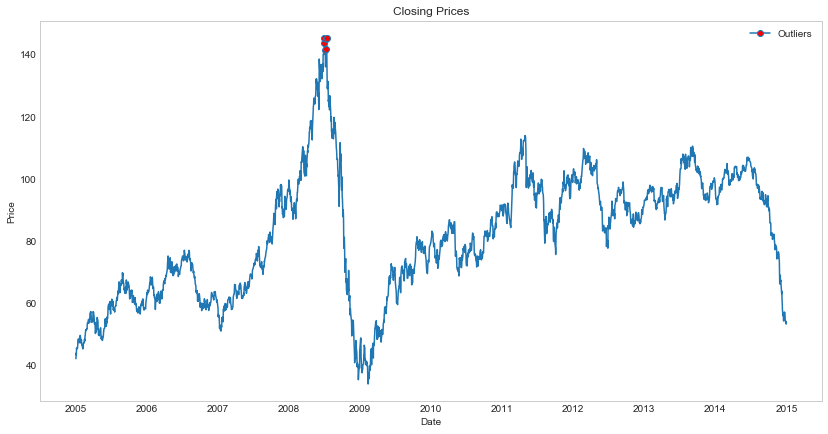

Number of data points: 2517
Number of outliers: 6


In [14]:
check_outliers(cl)

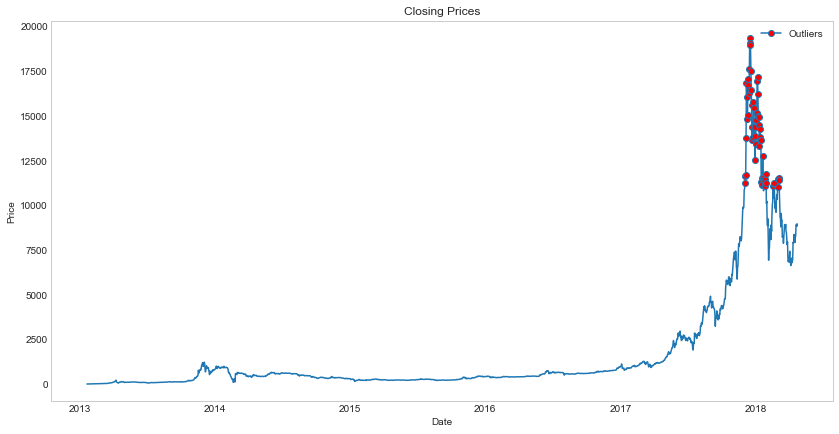

Number of data points: 1919
Number of outliers: 63


In [15]:
check_outliers(btc)

Each market has its outliers but they were due to the market itself making a strong move away from the mean value for the entire time series.  This is not uncommon for commodities and cryptocurrencies.  

In looking at the chart and having experience with these products I am comfortable saying that none of the points are far off due to inaccurate data.

At this point I am comfortable with the data and therefore can insert it into the database.  Then it will be time to move on to manipulation, by creating new columns for the indicators that I want to explore.

Here is the script for entering the data into the **Daily_Prices** table of the SQL database.

In [27]:
# Set table_name
table_name = 'Daily_Prices'

# Create the column name list for database insertion
cols = ['data_id', 'symbol', 'date', 'open', 'high', 'low', 'close', 'volume']

# Open a connection to the database
conn = sqlite3.connect(sqlite_file)
c = conn.cursor()

# Iterate through all symbols and then the dataframe to get all price data
for symbol, df in prod_dict.items():
    data_id = products[symbol][0]
    
    for i, row in df.iterrows():
        date = i.strftime('%Y-%m-%d')
        # Set params and insert row into database
        params = (data_id, symbol, date, row.open, row.high, row.low, row.close, row.volume)
        c.execute("INSERT INTO {tn} ({c0}, {c1}, {c2}, {c3}, {c4}, {c5}, {c6}, {c7}) VALUES (?, ?, ?, ?, ?, ?, ?, ?)"\
            .format(tn=table_name, c0=cols[0], c1=cols[1], c2=cols[2], c3=cols[3], c4=cols[4],\
            c5=cols[5], c6=cols[6], c7=cols[7]), params)

# Close connection to database
conn.commit()
conn.close()

## Data Manipulation

The next step in the analysis is to add columns to each product's dataframe to represent the specific indicators that we are interested in observing.  These can all be calculated from the current, **open, high, low, close, volume** data that we have.  

We also want to add columns that track future price changes.  I am choosing to look at a few different time frames, next day, 5 days out, 10 days out, and 20 days out.  Once we have columns for each indicator as a binary (0 if no signal, 1 if signal) and columns for the future returns from that point we can analyze which (if any) of the indicators shows promise for consistently predicting future returns.

Below is the code to add each column we need.  In the end, just passing a dataframe which is formatted as we have setup in the above analysis to the `add_all_indicators` function will do all the work.

In [16]:
def vol_bo(row, direction):
    ''' This is a helper function to use in volume breakout column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if row['volume'] > (2 * row['20day_ave_vol']):
        if (direction == 'long') and (row['close_gt_prev_h'] > 0.0):
            return 1
        elif (direction == 'short') and (row['close_lt_prev_l'] < 0.0):
            return 1
        else:
            return 0

def range_bo(row, direction):
    ''' This is a helper function to use in range breakout column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['high'] > row['20day_high']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['low'] < row['20day_low']:
            return 1
        else:
            return 0

def ma_signal(row, ma, direction):
    ''' This is a helper function to use in all moving average columns creation.  It takes
        in a row of a dataframe, a length of time and a direction of trade, and returns
        1 if a breakout has occured, 0 if not.

        Args: row - row of a dataframe
              ma - length of time for moving average
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['close'] > row['ma{}'.format(ma)]:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['close'] < row['ma{}'.format(ma)]:
            return 1
        else:
            return 0

def bb_signal(row, direction):
    ''' This is a helper function to use in all bollinger band column creation.  It takes
        in a row of a dataframe and a direction of trade, and returns 1 if a breakout
        has occured, 0 if not.

        Args: row - row of a dataframe
              direction - 'long' or 'short'

        Return: 1 if volume breakout occured, 0 if not
    '''
    if direction == 'long':
        if row['low'] < row['bb_low']:
            return 1
        else:
            return 0
    if direction == 'short':
        if row['high'] > row['bb_high']:
            return 1
        else:
            return 0

def add_all_indicators(df):
    ''' This function takes in a cleaned dataframe of price information and uses
        the helper functions to add all relevant indicators as columns
        to the dataframe.

        Args: df - cleaned dataframe of price information

        Return: df - cleaned dataframe with added columns for all indicators
    '''
    # All columns for 20day volume breakout indicator
    df['20day_ave_vol'] = df.volume.rolling(window=20, center=False).mean().shift(1)
    df['close_gt_prev_h'] = df['close'] - df['high'].shift(1)
    df['close_lt_prev_l'] = df['close'] - df['low'].shift(1)
    df['vol_bo_long'] = df.apply(lambda row: vol_bo(row, direction='long'), axis=1)
    df['vol_bo_short'] = df.apply(lambda row: vol_bo(row, direction='short'), axis=1)
    df['vol_bo_long'].fillna(value=0, inplace=True)
    df['vol_bo_short'].fillna(value=0, inplace=True)

    # All columns for 20day range breakout indicator
    df['20day_high'] = df.high.rolling(window=20, center=False).max().shift(1)
    df['20day_low'] = df.low.rolling(window=20, center=False).min().shift(1)
    df['range_bo_long'] = df.apply(lambda row: range_bo(row, direction='long'), axis=1)
    df['range_bo_short'] = df.apply(lambda row: range_bo(row, direction='short'), axis=1)

    # All columns for moving average indicators
    df['ma20'] = df['close'].rolling(window=20, center=False).mean()
    df['ma50'] = df['close'].rolling(window=50, center=False).mean()
    df['ma100'] = df['close'].rolling(window=100, center=False).mean()
    df['ma20_long'] = df.apply(lambda row: ma_signal(row, ma=20, direction='long'), axis=1)
    df['ma20_short'] = df.apply(lambda row: ma_signal(row, ma=20, direction='short'), axis=1)
    df['ma50_long'] = df.apply(lambda row: ma_signal(row, ma=50, direction='long'), axis=1)
    df['ma50_short'] = df.apply(lambda row: ma_signal(row, ma=50, direction='short'), axis=1)
    df['ma100_long'] = df.apply(lambda row: ma_signal(row, ma=100, direction='long'), axis=1)
    df['ma100_short'] = df.apply(lambda row: ma_signal(row, ma=100, direction='short'), axis=1)

    # All columns for bollinger band indicators
    df['bb_high'] = df['ma20'] + (2 * df['close'].rolling(window=20, center=False).std())
    df['bb_low'] = df['ma20'] - (2 * df['close'].rolling(window=20, center=False).std())
    df['bb_long'] = df.apply(lambda row: bb_signal(row, direction='long'), axis=1)
    df['bb_short'] = df.apply(lambda row: bb_signal(row, direction='short'), axis=1)

    # All columns for percentage change for timeframe into the future
    df['pct_change_1day'] = df['close'].pct_change()
    df['pct_change_5day'] = df['close'].pct_change(periods=5)
    df['pct_change_10day'] = df['close'].pct_change(periods=10)
    df['pct_change_20day'] = df['close'].pct_change(periods=20)

    return df

Lets check out how it works for Crude Oil and Bitcoin

In [17]:
cl.head()

,open,high,low,close,volume
Date,,,,,
2005-01-03,43.10,43.10,41.25,42.12,69484.0
2005-01-04,42.18,44.13,41.85,43.91,100665.0
2005-01-05,43.90,44.00,42.60,43.39,91011.0
2005-01-06,43.39,45.75,42.80,45.56,122411.0
2005-01-07,45.50,46.10,44.75,45.43,99725.0


In [18]:
cl_indicators = add_all_indicators(cl)
cl_indicators.tail()

,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,56.80,57.15,55.07,55.84,174969.0,358766.18,-1.72,0.78,0.0,0.0,...,0,1,72.792675,50.138525,0,0,-0.022409,-0.013393,-0.083689,-0.246322
2014-12-26,55.86,56.59,54.51,54.73,138280.0,352792.28,-2.42,-0.34,0.0,0.0,...,0,1,70.647242,50.387958,0,0,-0.019878,0.008662,-0.087073,-0.257294
2014-12-29,55.05,55.74,52.90,53.61,253089.0,346788.83,-2.98,-0.90,0.0,0.0,...,0,1,70.104360,49.676840,0,0,-0.020464,-0.059606,-0.072652,-0.189569
2014-12-30,53.72,54.32,52.70,54.12,230228.0,331802.13,-1.62,1.22,0.0,0.0,...,0,1,68.713782,49.579418,0,0,0.009513,-0.020630,-0.032016,-0.215652
2014-12-31,53.87,54.02,52.44,53.27,247510.0,317298.38,-1.05,0.57,0.0,0.0,...,0,1,67.645476,49.286724,0,0,-0.015706,-0.067402,-0.048682,-0.203499


In [31]:
cl_indicators.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2517.0,81.796207,19.832869,34.360000,65.680000,82.550000,96.900000,145.190000
high,2517.0,82.893532,19.961713,36.250000,66.560000,83.720000,97.820000,147.270000
low,2517.0,80.582003,19.695067,33.550000,64.650000,81.250000,95.560000,143.220000
close,2517.0,81.779758,19.855341,33.980000,65.820000,82.550000,96.920000,145.290000
volume,2517.0,242044.416712,95788.999248,50742.000000,176838.400000,242868.000000,301777.000000,670082.000000
20day_ave_vol,2497.0,242391.874480,77703.758445,89659.910000,213491.190000,249613.120000,293932.000000,436907.800000
close_gt_prev_h,2516.0,-1.109487,1.958492,-12.200000,-2.040000,-0.856000,0.080000,10.160000
close_lt_prev_l,2516.0,1.202332,1.864001,-8.680000,0.159500,1.088000,2.230000,16.930000
vol_bo_long,2517.0,0.000397,0.019932,0.000000,0.000000,0.000000,0.000000,1.000000
vol_bo_short,2517.0,0.001589,0.039841,0.000000,0.000000,0.000000,0.000000,1.000000


And for Bitcoin

In [19]:
btc.head()

,open,high,low,close,volume
Date,,,,,
2013-01-20,15.70,16.98,15.63,16.80,1007686.44
2013-01-21,16.80,17.59,16.65,17.26,1045898.98
2013-01-22,17.26,17.59,16.80,17.50,851188.37
2013-01-23,17.50,19.19,15.61,16.90,3053222.09
2013-01-24,16.90,17.80,15.39,17.40,1345890.12


In [20]:
btc_indicators = add_all_indicators(btc)
btc.tail()

,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-18,8189.92,8321.01,8136.42,8301.82,6.020990e+08,7.864628e+08,55.25,392.90,0.0,0.0,...,0,1,8620.299346,6165.043654,0,0,0.013658,0.034816,0.222739,0.211280
2018-04-19,8301.82,8945.14,8243.49,8877.08,9.799949e+08,7.373340e+08,556.07,740.66,0.0,0.0,...,0,1,8863.815257,6114.858743,0,1,0.069293,0.059731,0.291950,0.278424
2018-04-20,8877.15,9047.82,8631.18,8935.72,8.290734e+08,7.405637e+08,-9.42,692.23,0.0,0.0,...,0,1,9075.308304,6113.353696,0,0,0.006606,0.105937,0.280716,0.307187
2018-04-21,8935.85,9043.98,8788.44,8823.36,6.101831e+08,7.375230e+08,-224.46,192.18,0.0,0.0,...,0,1,9238.122993,6125.415007,0,0,-0.012574,0.113831,0.112974,0.247189
2018-04-22,8823.46,9025.73,8804.20,8965.92,5.214659e+08,7.305891e+08,-78.06,177.48,0.0,0.0,...,0,1,9411.171461,6105.528539,0,0,0.016157,0.094745,0.135054,0.206021


In [34]:
btc_indicators.describe().T

,count,mean,std,min,25%,50%,75%,max
open,2001.0,1.514856e+03,3.010058e+03,10.170000,2.364800e+02,4.450400e+02,9.043700e+02,1.934660e+04
high,2001.0,1.576502e+03,3.150620e+03,10.650000,2.403900e+02,4.545500e+02,9.256100e+02,1.987062e+04
low,2001.0,1.443244e+03,2.828414e+03,9.740000,2.323800e+02,4.354200e+02,8.699900e+02,1.875091e+04
close,2001.0,1.518286e+03,3.012241e+03,10.170000,2.365300e+02,4.452800e+02,9.045200e+02,1.934549e+04
volume,2001.0,1.722630e+08,4.823197e+08,109479.890000,4.024750e+06,1.549152e+07,4.908247e+07,6.245732e+09
20day_ave_vol,1981.0,1.698772e+08,4.400831e+08,268276.273500,4.588432e+06,1.688024e+07,4.765211e+07,2.907625e+09
close_gt_prev_h,2000.0,-5.480217e+01,2.949217e+02,-3636.860000,-1.990000e+01,-4.985000e+00,4.600000e-01,3.007110e+03
close_lt_prev_l,2000.0,7.841205e+01,3.268346e+02,-2134.220000,1.290000e+00,7.860000e+00,3.308250e+01,5.188550e+03
vol_bo_long,2001.0,4.397801e-02,2.050975e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
vol_bo_short,2001.0,2.098951e-02,1.433849e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00


Now lets take a look at a simple bar plot showing the number of trade signals for each strategy.

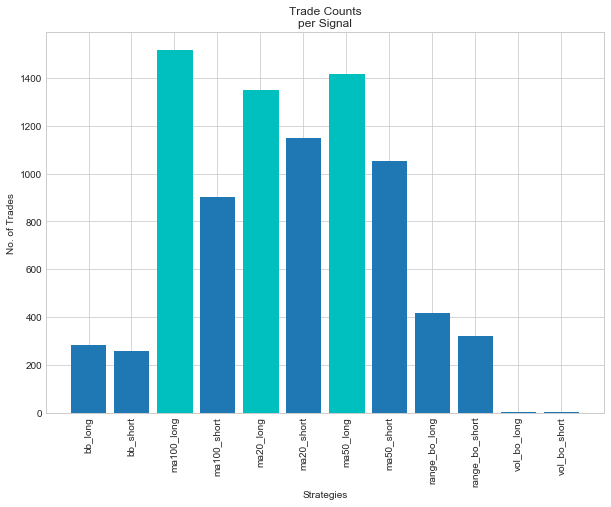

In [33]:
# Get the trade signal columns of the dataframe
cl_signals = cl_indicators[['vol_bo_long', 'vol_bo_short', 'range_bo_long', 'range_bo_short',
                       'ma20_long', 'ma20_short', 'ma50_long', 'ma50_short', 'ma100_long',
                       'ma100_short', 'bb_long', 'bb_short']]

# Put the strategy names and counts into lists
signal_names = [signal for signal in cl_signals.columns]
signal_counts = [cl_signals[signal].value_counts()[1] for signal in cl_signals.columns]

# Plot 
plt.figure(figsize=(10,7))
barlist = plt.bar(signal_names, signal_counts)
barlist[4].set_color('c')
barlist[6].set_color('c')
barlist[8].set_color('c')
plt.title('Trade Counts\nper Signal')
plt.xlabel('Strategies')
plt.ylabel('No. of Trades')
plt.xticks(rotation=90)

plt.savefig('crude_trade_counts.png', bbox_inches='tight')
plt.show()

And for Bitcoin

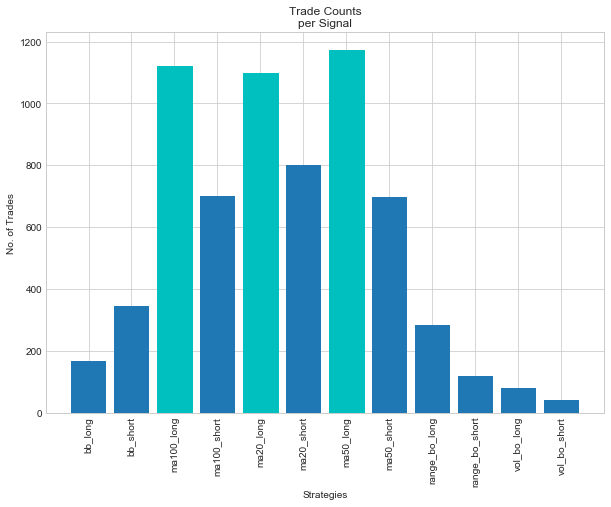

In [35]:
# Get the trade signal columns of the dataframe
btc_signals = btc_indicators[['vol_bo_long', 'vol_bo_short', 'range_bo_long', 'range_bo_short',
                       'ma20_long', 'ma20_short', 'ma50_long', 'ma50_short', 'ma100_long',
                       'ma100_short', 'bb_long', 'bb_short']]

# Put the strategy names and counts into lists
signal_names = [signal for signal in btc_signals.columns]
signal_counts = [btc_signals[signal].value_counts()[1] for signal in btc_signals.columns]

# Plot 
plt.figure(figsize=(10,7))
barlist = plt.bar(signal_names, signal_counts)
barlist[4].set_color('c')
barlist[6].set_color('c')
barlist[8].set_color('c')
plt.title('Trade Counts\nper Signal')
plt.xlabel('Strategies')
plt.ylabel('No. of Trades')
plt.xticks(rotation=90)

plt.savefig('bitcoin_trade_counts.png', bbox_inches='tight')
plt.show()

## Initial Exploration

Now that we have all the data and indicators that we need, it is time to explore the real question at hand, do any of these indicators do a good job of predicting future prices.

In order to do this we will create a plot of the future returns of a product after each signal is triggered and see if the distribution is consistently around zero (no predictive value), above (positive predictive value), or below (negative predictive value).  Keep in mind that if we find an indicator that consistently predicts negative returns all we have to do is change the entry direction in order to create a winning strategy.

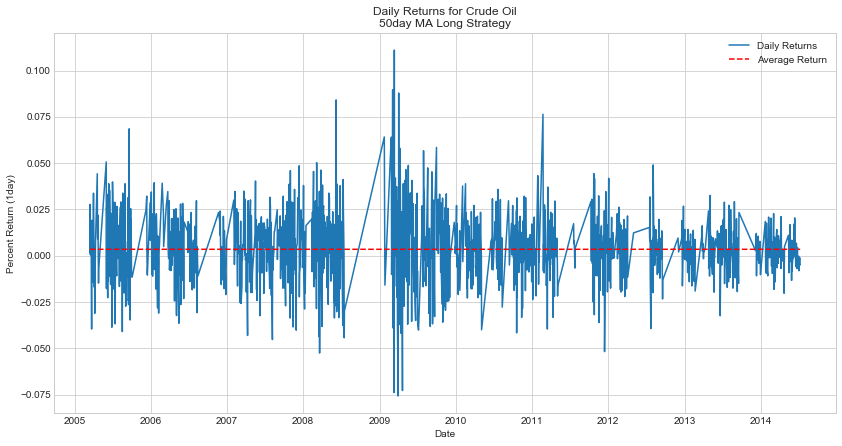

Average return: 0.003441966559424432
Number of trades: 1417


In [37]:
# Get the data for Crude Oil 50day long moving average signal, and mean return
cl_50ma_long = cl_indicators[cl_indicators['ma50_long'] == 1]
mean_pc = cl_50ma_long.pct_change_1day.mean()

# Plot the 1day returns
plt.figure(figsize=(14,7))

plt.plot(cl_50ma_long.index, cl_50ma_long.pct_change_1day, label='Daily Returns')
plt.plot(cl_50ma_long.index, [mean_pc]*len(cl_50ma_long.pct_change_1day),
            color='r', linestyle='--', label='Average Return')
plt.title('Daily Returns for Crude Oil\n50day MA Long Strategy')
plt.xlabel('Date')
plt.ylabel('Percent Return (1day)')
plt.legend(loc='best')

plt.savefig('crude_50ma_long_1day_returns.png', bbox_inches='tight')
plt.show()
print('Average return: {}'.format(mean_pc))
print('Number of trades: {}'.format(len(cl_50ma_long)))

And for the short 50day moving aveage strategy

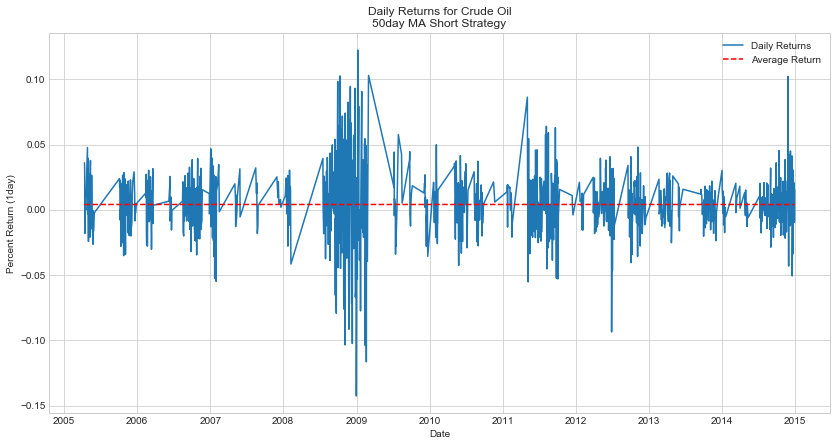

Average return: 0.004114335121237718
Number of trades: 1051


In [38]:
# Get the data for Crude Oil 50day long moving average signal, and mean return
cl_50ma_short = cl_indicators[cl_indicators['ma50_short'] == 1]
mean_pc = -1.0 * (cl_50ma_short.pct_change_1day.mean())

# Plot the 1day returns
plt.figure(figsize=(14,7))

plt.plot(cl_50ma_short.index, -1.0 * (cl_50ma_short.pct_change_1day), label='Daily Returns')
plt.plot(cl_50ma_short.index, [mean_pc]*len(cl_50ma_short.pct_change_1day),
            color='r', linestyle='--', label='Average Return')
plt.title('Daily Returns for Crude Oil\n50day MA Short Strategy')
plt.xlabel('Date')
plt.ylabel('Percent Return (1day)')
plt.legend(loc='best')

plt.savefig('crude_50ma_short_1day_returns.png', bbox_inches='tight')
plt.show()
print('Average return: {}'.format(mean_pc))
print('Number of trades: {}'.format(len(cl_50ma_short)))

So this looks like a good start.  With any trading strategy it is good to see positive results in each direction of trade.  It is a very simple way to show this is possibly a robust strategy, not one that finds winners in one direction but would just give back those gains on signals in the other direction.  

From here we will create a function to analyze this **signal-return** relationship for each signal, and for each timeframe of returns.

First I abstract this last analysis section out into a functon to be used to explore other signal-return relationships.

In [39]:
def plot_returns(df, signal, timeframe=1):
    ''' This function takes in a dataframe of price and indicator information, as well as the
        signal and timeframe for desired analysis.  It then plots a line chart of the percent
        returns over the given timeframe, for each signal in the dataset.
        
        Args: df - dataframe of price and indicator information
              signal - string name of the desired indicator signal
              timeframe - int of number of days into the future to show returns for (1, 5, 10, 20)
        
        Return: None - plots the input information
    '''
    # Get the relevant data from the dataframe and set timeframe string
    df_signal = df[df[signal] == 1]
    returns = 'pct_change_{}day'.format(timeframe)
    
    # Find out if signal is long or short and calculate the mean
    is_long = re.search('long$', signal)
    is_short = re.search('short$', signal)
    
    if is_long:
        mean_pc = df_signal[returns].mean()
    elif is_short:
        mean_pc = -1.0 * df_signal[returns].mean()
    else:
        return 'No such trading strategy'

    # Plot the 1day returns
    plt.figure(figsize=(14,7))
    
    if is_long:
        plt.plot(df_signal.index, df_signal[returns], label='Daily Returns')
    else:
        plt.plot(df_signal.index, -1.0 * (df_signal[returns]), label='Daily Returns')

    plt.plot(df_signal.index, [mean_pc]*len(df_signal[returns]),
                color='r', linestyle='--', label='Average Return')
    
    plt.title('Returns\nStrategy: {}\nTimeframe: {}'.format(signal, returns))
    plt.xlabel('Date')
    plt.ylabel('{}'.format(returns))
    plt.legend(loc='best')

    plt.show()
    print('Average return: {}'.format(mean_pc))
    print('Number of trades: {}'.format(len(df_signal)))

Now to create a function that can summarize important return statistics so we can compare signals across products, sectors, timeframes, etc.

In [36]:
def return_stats(product, df, signal, timeframe=1):
    ''' This function takes in a product, dataframe of price and indicator information, as well as a
        trading strategy signal and a timeframe, then returns important statistics about the
        percentage returns of the strategy over the total dataset, which is used for further analysis.
        
        Args: df - dataframe of price and indicator information
              signal - string name of the desired indicator signal
              timeframe - int of number of days into the future to show returns for (1, 5, 10, 20)
        
        Return: list [product, signal, timeframe, signals per day, mean return, std return, min, max, 25%, 75%]
    '''
    # Get the relevant data from the dataframe and set timeframe string
    df_signal = df[df[signal] == 1]
    returns = 'pct_change_{}day'.format(timeframe)
    
    # Find out if signal is long or short and calculate the mean
    is_long = re.search('long$', signal)
    is_short = re.search('short$', signal)
    
    if is_long:
        mean_pc = df_signal[returns].mean()
    elif is_short:
        mean_pc = -1.0 * df_signal[returns].mean()
    else:
        return 'No such trading strategy'
    
    # Calculate return statistics
    signal_count = len(df_signal)
    signals_per_day = len(df_signal) / len(df)
    std_pc = df_signal[returns].std()
    min_pc = df_signal[returns].min()
    max_pc = df_signal[returns].max()
    q25_pc = df_signal[returns].quantile(q=0.25)
    q75_pc = df_signal[returns].quantile(q=0.75)
    
    return [product, signal, timeframe, signal_count, signals_per_day, mean_pc, std_pc, min_pc, max_pc, q25_pc, q75_pc]

Here is an example of the Crude Oil stats for the 50day moving average long strategy for 1day returns.

In [37]:
cl_50ma_long_stats = return_stats('CL', cl, 'ma50_long')

# Print summary
print('Total number of signals: {}'.format(cl_50ma_long_stats[3]))
print('Number of signals per trading day: {0:.2f}'.format(cl_50ma_long_stats[4]))
print('Average return: {:.2%}'.format(cl_50ma_long_stats[5]))
print('Standard deviation of return: {:.2%}'.format(cl_50ma_long_stats[6]))
print('Minimum return: {:.2%}'.format(cl_50ma_long_stats[7]))
print('Maximum return: {:.2%}'.format(cl_50ma_long_stats[8]))
print('25th percentile return: {:.2%}'.format(cl_50ma_long_stats[9]))
print('75th percentile return: {:.2%}'.format(cl_50ma_long_stats[10]))

Total number of signals: 1417
Number of signals per trading day: 0.56
Average return: 0.34%
Standard deviation of return: 1.85%
Minimum return: -7.58%
Maximum return: 11.10%
25th percentile return: -0.74%
75th percentile return: 1.39%


These stats that we have for each signal and timeframe are important to look at, and our main analysis is based on determining whether or not we can find consistent returns across strategies, products, sectors, timeframes, etc.  The best way to do this would be to have all this return data stored in a dataframe, with the corresponding product, signal, timeframe, etc.  

So the final task here is to create a blank dataframe with the column headers and iterate through the prod_dict, for each trade signal, and for each timeframe, then enter the relevant data into the dataframe.  That will be the goal of these next few cells.  From there it will just be visualizing our findings.

In [38]:
# Create the dataframe, a list of all signals and a list of all timeframes
returns_df = pd.DataFrame(columns=['product', 'signal', 'timeframe',
                              'signal_count', 'signals_per_day', 'ave_return', 'std_return',
                              'min_return', 'max_return', 'q25_return', 'q75_return'])

signal_list = ['vol_bo_long', 'vol_bo_short', 'range_bo_long', 'range_bo_short',
                       'ma20_long', 'ma20_short', 'ma50_long', 'ma50_short', 'ma100_long',
                       'ma100_short', 'bb_long', 'bb_short']

timeframe_list = [1, 5, 10, 20]

Before we get into adding all the data to this new dataframe, we need to remember that not all the `prod_dict` dfs have been cleaned and processed with indicator columns yet.  We have only shown examples of a few.  So here we clean and process all dfs in the main dict.

In [39]:
# Get a list of symbols without CL and BTC, since we already processed them for examples
symbols = list(prod_dict.keys())
symbols.remove('CL')
symbols.remove('BTC')

# Iterate through prod_dict for symbol in symbols and apply add_all_indicators
for prod, df in prod_dict.items():
    if prod in symbols:
        add_all_indicators(df)

Check to see that the columns have been appended properly.

In [40]:
gc = prod_dict['GC']
gc.tail()

,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-24,1176.8,1181.2,1172.7,1173.5,43632.0,158831.94,-11.4,1.1,0.0,0.0,...,0,1,1236.481767,1165.506233,0,0,-0.003820,-0.017581,-0.045469,-0.019944
2014-12-26,1175.2,1199.1,1175.2,1195.3,67481.0,152136.58,14.1,22.6,0.0,0.0,...,0,1,1236.441338,1165.362662,0,0,0.018577,0.000418,-0.024723,-0.001537
2014-12-29,1194.9,1197.5,1178.6,1181.9,86152.0,150354.58,-17.2,6.7,0.0,0.0,...,0,1,1235.896807,1166.553193,0,0,-0.011211,-0.011789,-0.033211,0.005496
2014-12-30,1182.9,1210.9,1180.5,1200.4,142350.0,144371.55,2.9,21.8,0.0,0.0,...,0,1,1234.089504,1166.590496,0,0,0.015653,0.017461,-0.006045,-0.014531
2014-12-31,1199.8,1203.9,1179.5,1184.1,71734.0,134341.95,-26.8,3.6,0.0,0.0,...,0,1,1234.098943,1165.051057,0,0,-0.013579,0.005178,-0.008541,-0.012756


In [41]:
xrp = prod_dict['XRP']
xrp.tail()

,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2018-04-18,0.7132,0.7876,0.7047,0.7828,8.104002e+07,5.276356e+07,0.0540,0.1298,0.0,0.0,...,0,1,0.765343,0.374977,0,1,0.097588,0.222934,0.610037,0.568737
2018-04-19,0.7828,0.9367,0.7828,0.9229,2.436352e+08,5.322349e+07,0.1353,0.2182,1.0,0.0,...,1,0,0.839048,0.343532,0,1,0.178973,0.330786,0.880016,0.844693
2018-04-20,0.9229,0.9238,0.8061,0.8655,1.665466e+08,6.372278e+07,-0.0712,0.0827,0.0,0.0,...,0,1,0.880760,0.340500,0,1,-0.062195,0.303857,0.603075,0.808022
2018-04-21,0.8655,0.9139,0.8394,0.8620,9.372173e+07,7.009755e+07,-0.0618,0.0559,0.0,0.0,...,0,1,0.915343,0.342747,0,0,-0.004044,0.316432,0.343516,0.746000
2018-04-22,0.8620,0.8848,0.8452,0.8749,7.175870e+07,7.338840e+07,-0.0390,0.0355,0.0,0.0,...,0,1,0.948996,0.341854,0,0,0.014965,0.226725,0.361924,0.598575


Now that we have all the right columns for each dataframe we can put the return data into our blank dataframe.

In [46]:
add_all_indicators(prod_dict['BTC'])

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

/Users/Frank/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,open,high,low,close,volume,20day_ave_vol,close_gt_prev_h,close_lt_prev_l,vol_bo_long,vol_bo_short,...,ma100_long,ma100_short,bb_high,bb_low,bb_long,bb_short,pct_change_1day,pct_change_5day,pct_change_10day,pct_change_20day
Date,,,,,,,,,,,,,,,,,,,,,
2012-10-25,10.86,10.95,9.74,10.17,1.020617e+06,NaN,NaN,NaN,0.0,0.0,...,0,0,NaN,NaN,0,0,NaN,NaN,NaN,NaN
2012-10-26,10.17,10.84,9.82,10.26,4.967475e+05,NaN,-0.69,0.52,0.0,0.0,...,0,0,NaN,NaN,0,0,0.008850,NaN,NaN,NaN
2012-10-27,10.26,10.95,10.25,10.70,2.366405e+05,NaN,-0.14,0.88,0.0,0.0,...,0,0,NaN,NaN,0,0,0.042885,NaN,NaN,NaN
2012-10-28,10.70,10.94,10.32,10.60,4.001735e+05,NaN,-0.35,0.35,0.0,0.0,...,0,0,NaN,NaN,0,0,-0.009346,NaN,NaN,NaN
2012-10-29,10.60,10.89,10.58,10.89,2.798431e+05,NaN,-0.05,0.57,0.0,0.0,...,0,0,NaN,NaN,0,0,0.027358,NaN,NaN,NaN
2012-10-30,10.89,11.21,10.71,11.20,4.483598e+05,NaN,0.31,0.62,0.0,0.0,...,0,0,NaN,NaN,0,0,0.028466,0.101278,NaN,NaN
2012-10-31,11.20,11.28,10.40,10.57,5.503275e+05,NaN,-0.64,-0.14,0.0,0.0,...,0,0,NaN,NaN,0,0,-0.056250,0.030214,NaN,NaN
2012-11-01,10.57,10.80,10.33,10.47,2.589578e+05,NaN,-0.81,0.07,0.0,0.0,...,0,0,NaN,NaN,0,0,-0.009461,-0.021495,NaN,NaN
2012-11-02,10.47,10.65,10.40,10.64,1.763451e+05,NaN,-0.16,0.31,0.0,0.0,...,0,0,NaN,NaN,0,0,0.016237,0.003774,NaN,NaN


In [42]:
# Set variable to keep track of index in dataframe
i = 0

# Iterate through each product, for each signal, for each timeframe    
for prod, df in prod_dict.items():
    for signal in signal_list:
        for timeframe in timeframe_list:
            # Insert row of data into dataframe
            returns_df.loc[i] = return_stats(prod, df, signal, timeframe)
            i += 1

We will print out the info on our new dataframe in order to check that things look good. 

In [43]:
returns_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1200 entries, 0 to 1199
Data columns (total 11 columns):
product            1200 non-null object
signal             1200 non-null object
timeframe          1200 non-null object
signal_count       1200 non-null object
signals_per_day    1200 non-null float64
ave_return         1188 non-null float64
std_return         1176 non-null float64
min_return         1188 non-null float64
max_return         1188 non-null float64
q25_return         1188 non-null float64
q75_return         1188 non-null float64
dtypes: float64(7), object(4)
memory usage: 112.5+ KB


It looks like we got through all iterations as we expected to see **1,200 total rows**, for our **25 products**, **12 signals**, and **4 timeframes**.

We do have some null values that we want to investigate.

In [44]:
returns_df[returns_df.std_return.isnull()]

,product,signal,timeframe,signal_count,signals_per_day,ave_return,std_return,min_return,max_return,q25_return,q75_return
0,CL,vol_bo_long,1,1,0.000397,0.039823,NaN,0.039823,0.039823,0.039823,0.039823
1,CL,vol_bo_long,5,1,0.000397,-0.018215,NaN,-0.018215,-0.018215,-0.018215,-0.018215
2,CL,vol_bo_long,10,1,0.000397,-0.000068,NaN,-0.000068,-0.000068,-0.000068,-0.000068
3,CL,vol_bo_long,20,1,0.000397,0.067599,NaN,0.067599,0.067599,0.067599,0.067599
48,HO,vol_bo_long,1,1,0.000396,0.003687,NaN,0.003687,0.003687,0.003687,0.003687
49,HO,vol_bo_long,5,1,0.000396,0.100618,NaN,0.100618,0.100618,0.100618,0.100618
50,HO,vol_bo_long,10,1,0.000396,0.142194,NaN,0.142194,0.142194,0.142194,0.142194
51,HO,vol_bo_long,20,1,0.000396,0.146510,NaN,0.146510,0.146510,0.146510,0.146510
52,HO,vol_bo_short,1,1,0.000396,0.014271,NaN,-0.014271,-0.014271,-0.014271,-0.014271
53,HO,vol_bo_short,5,1,0.000396,0.130234,NaN,-0.130234,-0.130234,-0.130234,-0.130234


There are two reasons for null values here, one is no signals for the given product/signal/timeframe combination.  The other is there only being 1 signal for the combination and therefore the standard deviation calculation is NaN, due to dividing by zero.  

In each case we can simply drop the columns without losing any significant information.

In [45]:
returns_df.dropna(inplace=True)
returns_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1176 entries, 4 to 1199
Data columns (total 11 columns):
product            1176 non-null object
signal             1176 non-null object
timeframe          1176 non-null object
signal_count       1176 non-null object
signals_per_day    1176 non-null float64
ave_return         1176 non-null float64
std_return         1176 non-null float64
min_return         1176 non-null float64
max_return         1176 non-null float64
q25_return         1176 non-null float64
q75_return         1176 non-null float64
dtypes: float64(7), object(4)
memory usage: 110.2+ KB


## Initial Research Findings

Now that we have a dataframe of return data lets explore it visually to generate some insights about the ability to consistently predict future price movements.

First lets simply look at the distribution of **ave_return**.

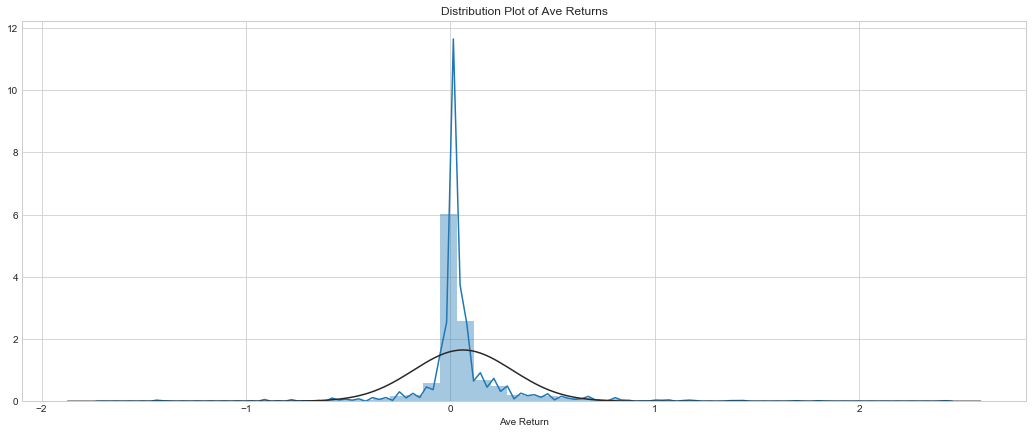

In [46]:
from scipy.stats import norm

fig, ax = plt.subplots(figsize=(18,7))

ax = sns.distplot(returns_df.ave_return, fit=norm)
ax.set(title='Distribution Plot of Ave Returns', xlabel='Ave Return')

plt.savefig('distplot_ave_return.png', bbox_inches='tight')

This distribution is clearly not normal, with most of the observations right around zero.  However it does appear that the mean is positive and the distribution is slightly skewed to the right.

In [47]:
print('Mean of ave_return: {}'.format(returns_df.ave_return.mean()))
print('Skewness of ave_return: {}'.format(returns_df.ave_return.skew()))
print('Kurtosis of ave_return: {}'.format(returns_df.ave_return.kurtosis()))

Mean of ave_return: 0.06103526174149802
Skewness of ave_return: 1.770193098641761
Kurtosis of ave_return: 21.106852301599222


This shows some promise that we have more winning strategies that losing ones and that hopefully the winners also have greater magnitude than the losers.

Now lets look at the top and bottom 100 combinations sorted by **ave_return**.

In [53]:
# Index by product and signal then take the top and bottom 100 combinations
top100 = returns_df.set_index(['product', 'signal'], drop=True).sort_values(by='ave_return', ascending=False)[:100]
bottom100 = returns_df.set_index(['product', 'signal'], drop=True).sort_values(by='ave_return')[:100]

In [54]:
top100.head()

,,timeframe,signal_count,signals_per_day,ave_return,std_return,min_return,max_return,q25_return,q75_return
product,signal,,,,,,,,,
XRP,range_bo_long,20,30,0.078329,2.677800,2.865334,0.102477,9.644337,0.408359,4.175874
XLM,vol_bo_long,20,16,0.046921,1.937158,1.166752,-0.083631,3.762110,0.964861,2.801516
XRP,vol_bo_long,20,26,0.067885,1.916933,2.783252,-0.248175,9.644337,0.248019,2.449687
XLM,range_bo_long,20,25,0.073314,1.678717,1.216300,0.142410,3.762110,0.547138,2.789645
EOS,range_bo_long,20,28,0.098940,1.609118,0.869831,0.194982,3.361702,0.956639,2.207234


In [55]:
bottom100.head()

,,timeframe,signal_count,signals_per_day,ave_return,std_return,min_return,max_return,q25_return,q75_return
product,signal,,,,,,,,,
XRP,bb_short,20,57,0.148825,-1.911211,2.518295,-0.189655,9.644337,0.244444,2.700691
XLM,bb_short,20,40,0.117302,-1.647313,1.134437,-0.100822,3.762110,0.540705,2.448912
EOS,bb_short,20,39,0.137809,-1.571822,0.905577,-0.125765,3.361702,0.912399,2.238692
BCH,bb_short,20,23,0.090909,-0.996021,1.050740,0.011200,3.404390,0.255354,1.122374
XRP,bb_short,10,57,0.148825,-0.975302,0.968764,0.009256,3.569563,0.183473,1.784294


This is a snapshot of the top and bottom , lets look at a visualization and make some observations.

In [58]:
top100.reset_index(inplace=True)
bottom100.reset_index(inplace=True)

/Users/Frank/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


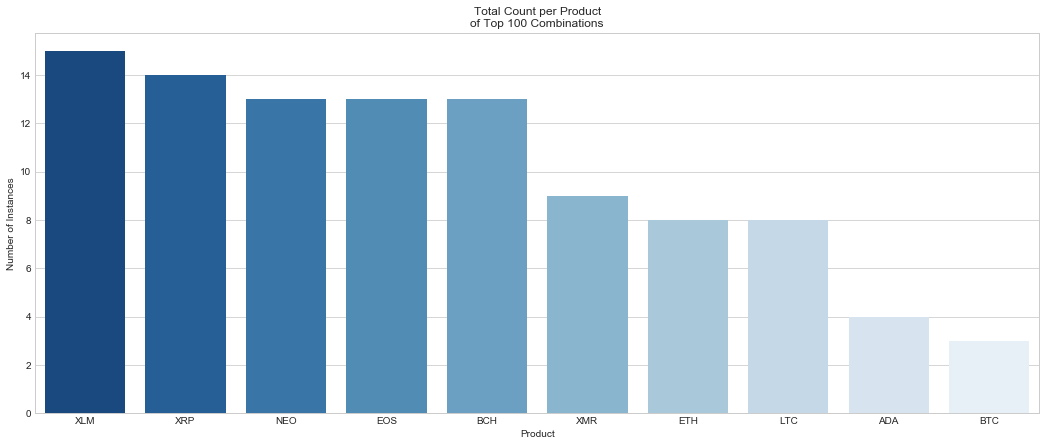

In [59]:
# Plot counts by product
fig, ax = plt.subplots(figsize=(18,7))


ax = sns.countplot(x='product', data=top100,
                   order=top100['product'].value_counts().index, palette=sns.color_palette('Blues_r', 10))

ax.set(title='Total Count per Product\nof Top 100 Combinations', xlabel='Product', ylabel='Number of Instances')
plt.savefig('countplot_top100.png', bbox_inches='tight')

/Users/Frank/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


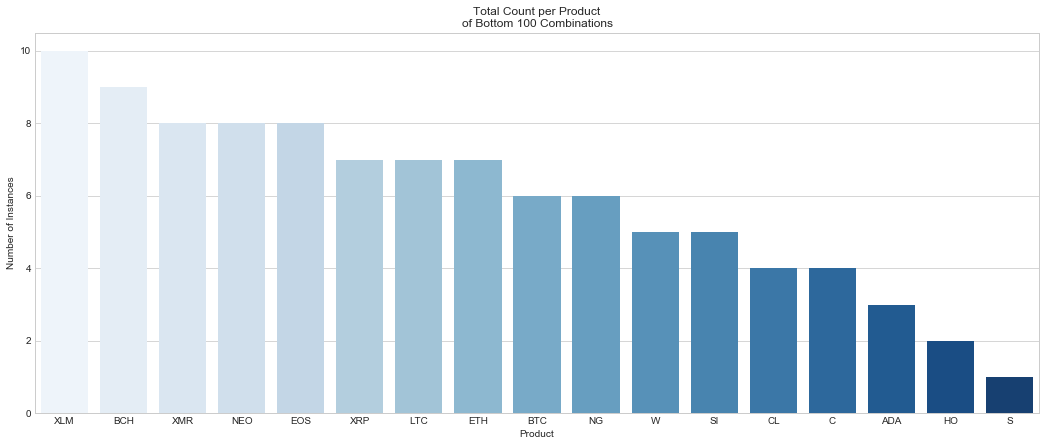

In [60]:
# Plot counts by product
fig, ax = plt.subplots(figsize=(18,7))

ax = sns.countplot(x='product', data=bottom100, 
                   order=bottom100['product'].value_counts().index, palette=sns.color_palette('Blues', 17))

ax.set(title='Total Count per Product\nof Bottom 100 Combinations', xlabel='Product', ylabel='Number of Instances')
plt.savefig('countplot_bottom100.png', bbox_inches='tight')

It turns out that **XLM** is the product in the most top100 combinations as well as the bottom100.  We can also see that **Cryptocurrencies** are clearly the most volatile class, all 10 that we tracked showed up in the top100 combinations as well as the bottom100.

In the bottom100 we see that all products from the **Grains** and **Energy** sectors made the list.  

Now for a breakdown of performance by **signal** lets check out this next plot.

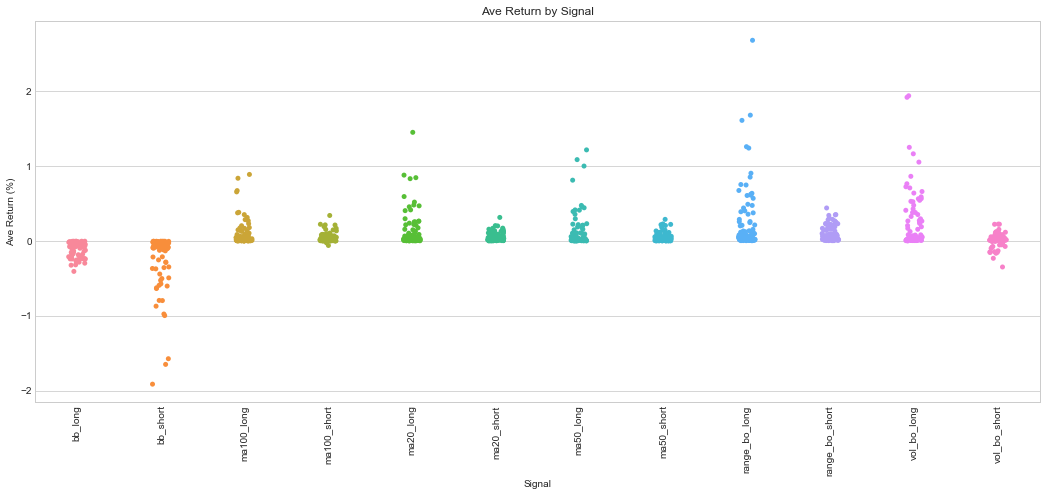

In [61]:
fig, ax = plt.subplots(figsize=(18,7))

ax = sns.stripplot(x='signal', y='ave_return', data=returns_df.sort_values(by='signal'), jitter=True)
ax.set(title='Ave Return by Signal', xlabel='Signal', ylabel='Ave Return (%)')
ax.tick_params(axis='x', rotation=90)

plt.savefig('stripplot_signal.png', bbox_inches='tight')

From here there are a couple of interesting observations.

1. The **Bollinger Band Signal**, which was our only **mean-reversion** signal, performed very poorly, for both directions.
2. The **Volume-Breakout Signal**, is the only one with mixed results in long vs. short entry types.
3. We had two different **break-out** strategies, and the **Range-Breakout** clearly performed better, having positive average returns for both trade directions.
4. **Trend-following** strategies worked well across the board in both directions no matter the timeframe for moving average.

Finally, lets examine a heatmap of **ave_return** per **product** and **signal** to get a broad view of things.

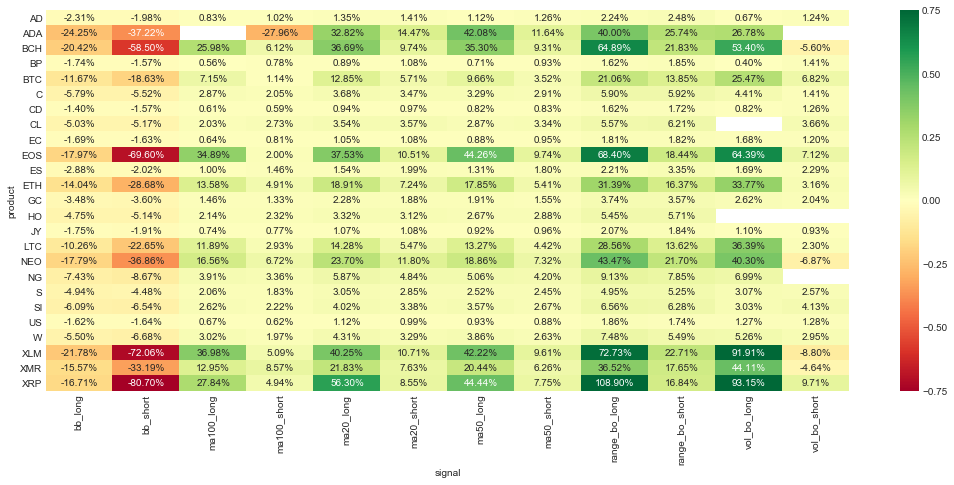

In [60]:
fig, ax = plt.subplots(figsize=(18,7))
df1 = returns_df.pivot_table(index='product', columns='signal', values='ave_return', aggfunc=np.mean)
sns.heatmap(df1, annot=True, fmt=".2%", ax=ax, cmap='RdYlGn', center=0.0, vmin=-0.75, vmax=0.75)
plt.savefig('heatmap.png', bbox_inches='tight')

This sums up all the analysis we have seen, the fact that the **Bollinger Band Signal** performed poorly across the board, **Cryptocurrencies** made up the highest and lowest returns, **Moving Average Trend Signals** were consistently good, etc.

## Final Steps

Now that we have our initial exploration done, I want to refine the analysis down in order to make a recommendation for a robust trading strategy across all products, or a portfolio of different strategies for different products, sectors, timeframes, etc.  To do so I will follow these final steps:

1. Filter out **Bollinger Band** strategy

1. Filter strategies down to those with a large number of data points

2. Search for the combinations that create high returns, based on product, sector, timeframe, etc.

3.  Make a recommendation for an individual strategy or basket of strategies to use in creating a trading system. 

In [62]:
# Remove all bb strats
df_final = returns_df[(returns_df['signal'] != 'bb_long') & (returns_df['signal'] != 'bb_short')]
df_final['signal'].value_counts()

ma100_short       100
ma50_long         100
ma20_short        100
range_bo_long     100
range_bo_short    100
ma50_short        100
ma20_long         100
ma100_long         96
vol_bo_long        92
vol_bo_short       88
Name: signal, dtype: int64

In [63]:
# Get a subset of data where the signal_count is at least 150
df_final = df_final[df_final['signal_count'] > 150]
df_final['product'].value_counts()

GC     32
S      32
HO     32
NG     32
CD     32
US     32
CL     32
SI     32
ES     32
C      32
AD     32
BP     32
EC     32
W      32
JY     32
BTC    28
LTC    24
ETH    24
XMR    16
XRP    16
XLM    12
Name: product, dtype: int64

We can see here that after filtering only the signals with at least 150 data points we lose some of the products.  We also need to take a deeper look into what strategies were dropped.

In [64]:
df_final['signal'].value_counts()

ma20_short        84
ma20_long         84
ma50_short        80
ma50_long         80
ma100_long        76
ma100_short       72
range_bo_long     64
range_bo_short    60
Name: signal, dtype: int64

So it looks like the `vol_bo_long` and `vol_bo_short` did not make the cut.  Finally we will look at each product and make sure that if a signal `long` is included than the `short` is there as well.  Otherwise we will drop because we dont want a strategy that only trades one way.

In [66]:
# Iterate through all products and print the unique signal names
for product in df_final['product'].unique():
    print(product)
    print('_______')
    print(df_final[df_final['product'] == product]['signal'].value_counts())

CL
_______
ma50_long         4
ma20_long         4
ma50_short        4
ma20_short        4
range_bo_short    4
range_bo_long     4
ma100_short       4
ma100_long        4
Name: signal, dtype: int64
HO
_______
ma50_long         4
ma20_long         4
ma50_short        4
ma20_short        4
range_bo_short    4
range_bo_long     4
ma100_short       4
ma100_long        4
Name: signal, dtype: int64
NG
_______
ma50_long         4
ma20_long         4
ma50_short        4
ma20_short        4
range_bo_short    4
range_bo_long     4
ma100_short       4
ma100_long        4
Name: signal, dtype: int64
GC
_______
ma50_long         4
ma20_long         4
ma50_short        4
ma20_short        4
range_bo_short    4
range_bo_long     4
ma100_short       4
ma100_long        4
Name: signal, dtype: int64
SI
_______
ma50_long         4
ma20_long         4
ma50_short        4
ma20_short        4
range_bo_short    4
range_bo_long     4
ma100_short       4
ma100_long        4
Name: signal, dtype: int64
AD
_______

Here we can see the rows we need to drop BTC-range_bo_long, XLM-all, and XMR-ma100_long, ma50_long.

In [67]:
# Create a dict of product:signal pairs to drop
drops = {'BTC': 'range_bo_long',
         'XLM': 'ma50_short',
         'XLM': 'ma20_short',
         'XMR': 'ma100_long',
         'XMR': 'ma50_long'}

# Iterate through key:value pairs and drop rows with those combinations
for product, signal in drops.items():
    df_final.drop(df_final[(df_final['product'] == product) & (df_final['signal'] == signal)].index, inplace=True)

Now check to see that it worked

In [68]:
df_final.drop(df_final[(df_final['product'] == 'XLM') & (df_final['signal'] == 'ma50_short')].index, inplace=True)

In [69]:
df_final.drop(df_final[(df_final['product'] == 'XMR') & (df_final['signal'] == 'ma100_long')].index, inplace=True)

In [70]:
df_final['product'].value_counts()

GC     32
S      32
HO     32
NG     32
CD     32
US     32
CL     32
SI     32
ES     32
C      32
AD     32
BP     32
EC     32
W      32
JY     32
LTC    24
BTC    24
ETH    24
XRP    16
XMR     8
XLM     4
Name: product, dtype: int64

Ok, now that we have the correct strategies for all with more than 150 data points we can dig deeper into those combinations with the best returns to see if we can uncover any patterns.

First, we need to do a little more data manipulation.  In the previous sections we broke up all strategies into **long** and **short** directions.  However, when recommending a strategy we want to combine each **long** and **short** in order to create an aggregated **ave_return** for the strategy.

Consolidate the strategies to form one column

In [71]:
def calculate_combined(df, prod, sig, tf, sig_map):
    ''' This function takes in a dataframe, product, signal, timeframe and signal_map and returns
        both the combined average return and total signal count for each strategy long/short combination.
        
        Args: df - the cleaned dataframe of price and return information
              prod - product name
              sig - signal name
              tf - timeframe
              sig_map - a dict that maps the long strategy to the short strategy
        
        Return: combined ave return, total signal count 
    '''
    # Get the individual counts, returns for long and short trades
    long_count, long_ave_return = df[(df['product'] == prod) & (df['signal'] == sig) &\
                                     (df['timeframe'] == tf)].iloc[0][['signal_count', 'ave_return']]
    short_count, short_ave_return = df[(df['product'] == prod) & (df['signal'] == sig_map[sig]) &\
                                       (df['timeframe'] == tf)].iloc[0][['signal_count', 'ave_return']]
    
    # Get total number of trades
    total_count = long_count + short_count
    
    # Calculate combined ave return
    combined_ave_return = ((long_count / total_count) * long_ave_return) +\
                            ((short_count / total_count) * short_ave_return)
    
    return combined_ave_return, total_count

Here we create the `signal_map` for each long/short side of strategies, as well as a list of timeframes.  Then we can iterate through all possible combinations and append to an empty list.

In [75]:
# Create a signal_map for each strategy pair
signal_map = {'range_bo_long': 'range_bo_short',
              'ma20_long': 'ma20_short',
              'ma50_long': 'ma50_short',
              'ma100_long': 'ma100_short'}

timeframes = [1, 5, 10, 20]

combined = []

# Iterate through each combination and append information
for product in df_final['product'].unique():
    for timeframe in timeframes:
        for signal in signal_map:
            if signal in list(df_final[df_final['product'] == product].signal):
                combined_return, combined_count = calculate_combined(df_final, product, signal, timeframe, signal_map)
                combined.append([product, signal[:-5], timeframe, combined_return, combined_count])
            
combined

IndexError: single positional indexer is out-of-bounds

In [73]:
# Put the data into a dataframe with properly named columns
df_combined = pd.DataFrame(combined)
df_combined.columns = ['product', 'signal', 'timeframe', 'ave_return', 'signal_count']
df_combined.head()

ValueError: Length mismatch: Expected axis has 0 elements, new values have 5 elements

With the combined strategies now created lets take a look at the top 5 combindations from each based on `ave_return`.

In [260]:
# Iterate over all products and print top 5 signal/timeframe combinations from combined dataframe
for product in df_combined['product'].unique():
    print(product)
    print(df_combined[df_combined['product'] == product].sort_values(by='ave_return', ascending=False)\
          .iloc[:5][['signal', 'timeframe', 'ave_return', 'signal_count']])
    print('________________________________________')

CL
      signal  timeframe  ave_return  signal_count
12  range_bo         20    0.097742           736
8   range_bo         10    0.072875           736
14      ma50         20    0.064500          2468
13      ma20         20    0.063714          2498
4   range_bo          5    0.050474           736
________________________________________
HO
      signal  timeframe  ave_return  signal_count
28  range_bo         20    0.090282           709
24  range_bo         10    0.070313           709
30      ma50         20    0.057119          2474
29      ma20         20    0.055137          2504
20  range_bo          5    0.049273           709
________________________________________
NG
      signal  timeframe  ave_return  signal_count
44  range_bo         20    0.142587           762
40  range_bo         10    0.106422           762
46      ma50         20    0.097048          2459
45      ma20         20    0.092615          2489
47     ma100         20    0.079985          2409
_________

It is clear from here that the `range_bo` strategy is the best for all traditional assets, and the `ma50` or `ma20` are best for cryptocurrencies.  

Next, I want to add a column for `total_return` to see if the results are the same.  

In [261]:
df_combined['total_return'] = df_combined['ave_return'] * df_combined['signal_count']
df_combined.head(10)

,product,signal,timeframe,ave_return,signal_count,total_return
0,CL,range_bo,1,0.012953,736,9.533485
1,CL,ma20,1,0.006127,2498,15.306472
2,CL,ma50,1,0.003728,2468,9.201433
3,CL,ma100,1,0.002705,2418,6.539863
4,CL,range_bo,5,0.050474,736,37.148864
5,CL,ma20,5,0.027394,2498,68.431118
6,CL,ma50,5,0.018621,2468,45.956814
7,CL,ma100,5,0.013017,2418,31.475483
8,CL,range_bo,10,0.072875,736,53.635986
9,CL,ma20,10,0.044840,2498,112.011000


In [262]:
# Iterate over all products and print top 5 signal/timeframe combinations from combined dataframe
for product in df_combined['product'].unique():
    print(product)
    print(df_combined[df_combined['product'] == product].sort_values(by='total_return', ascending=False)\
          .iloc[:5][['signal', 'timeframe', 'total_return', 'signal_count']])
    print('________________________________________')

CL
   signal  timeframe  total_return  signal_count
14   ma50         20    159.187039          2468
13   ma20         20    159.158147          2498
15  ma100         20    121.486171          2418
9    ma20         10    112.011000          2498
10   ma50         10     88.794702          2468
________________________________________
HO
   signal  timeframe  total_return  signal_count
30   ma50         20    141.313097          2474
29   ma20         20    138.062105          2504
31  ma100         20    113.915114          2424
25   ma20         10    107.909403          2504
26   ma50         10     81.878321          2474
________________________________________
NG
   signal  timeframe  total_return  signal_count
46   ma50         20    238.641743          2459
45   ma20         20    230.518485          2489
47  ma100         20    192.684355          2409
41   ma20         10    171.244547          2489
42   ma50         10    131.343466          2459
___________________________

The last column that I want to create is an **ave_yearly_return** column.  Since each product had a different number of data points in the original data set, we want to normalize the returns we are looking at.  This will put each strategy in the perspective of if you traded it for an entire year, what your expected return would look like.

First we need to get the number of data points for each product.

In [279]:
# Get total data points from original data set for each product
data_points = {}

# Iterate through all products and create dict entry with name:total data points key:value pair
for prod in prod_dict.keys():
    data_points[prod] = prod_dict[prod].shape[0] / 260
    
data_points

{'AD': 9.746153846153845,
 'ADA': 0.3923076923076923,
 'BCH': 0.9730769230769231,
 'BP': 9.738461538461538,
 'BTC': 7.665384615384616,
 'C': 9.692307692307692,
 'CD': 9.73076923076923,
 'CL': 9.680769230769231,
 'EC': 9.742307692307692,
 'EOS': 1.0884615384615384,
 'ES': 9.888461538461538,
 'ETH': 2.95,
 'GC': 9.676923076923076,
 'HO': 9.703846153846154,
 'JY': 9.734615384615385,
 'LTC': 4.9653846153846155,
 'NEO': 0.9576923076923077,
 'NG': 9.646153846153846,
 'S': 9.684615384615384,
 'SI': 9.646153846153846,
 'US': 9.653846153846153,
 'W': 9.680769230769231,
 'XLM': 1.3115384615384615,
 'XMR': 1.5269230769230768,
 'XRP': 1.4730769230769232}

Now we need to create a `lambda` function to use with the `apply()` method of a dataframe in order to calculate the **ave_yearly_return**.

In [280]:
def year_return(row, data_points_map):
    ''' This is a helper function that takes in a row of a dataframe as well as a map of product to total 
        number of data points in the original dataset.  It will be used to calculate an ave_yearly_return 
        column of the dataframe.
        
        Args: row - row of dataframe
              data_points_map - dict with product:total number of data points, as key:value pair
              
        Return: ave_yearly_return - ave_yearly_return of the specfic strategy given total data points
    '''
    # Get return per year
    return_per_dp = row['total_return'] / data_points_map[row['product']]
    
    return return_per_dp 
    

In [283]:
df_combined['ave_yearly_return'] = df_combined.apply(lambda row: year_return(row, data_points), axis=1)
df_combined.head(20)

,product,signal,timeframe,ave_return,signal_count,total_return,ave_yearly_return
0,CL,range_bo,1,0.012953,736,9.533485,0.984786
1,CL,ma20,1,0.006127,2498,15.306472,1.581121
2,CL,ma50,1,0.003728,2468,9.201433,0.950486
3,CL,ma100,1,0.002705,2418,6.539863,0.675552
4,CL,range_bo,5,0.050474,736,37.148864,3.837388
5,CL,ma20,5,0.027394,2498,68.431118,7.068769
6,CL,ma50,5,0.018621,2468,45.956814,4.747228
7,CL,ma100,5,0.013017,2418,31.475483,3.251341
8,CL,range_bo,10,0.072875,736,53.635986,5.540467
9,CL,ma20,10,0.044840,2498,112.011000,11.570465


Finally we can look at the same breakdown of top 5 strategies per product based on **ave_yearly_return**

In [282]:
# Iterate over all products and print top 5 signal/timeframe combinations from combined dataframe
for product in df_combined['product'].unique():
    print(product)
    print(df_combined[df_combined['product'] == product].sort_values(by='ave_yearly_return', ascending=False)\
          .iloc[:5][['signal', 'timeframe', 'ave_yearly_return', 'signal_count']])
    print('________________________________________')

CL
   signal  timeframe  ave_yearly_return  signal_count
14   ma50         20          16.443635          2468
13   ma20         20          16.440651          2498
15  ma100         20          12.549227          2418
9    ma20         10          11.570465          2498
10   ma50         10           9.172278          2468
________________________________________
HO
   signal  timeframe  ave_yearly_return  signal_count
30   ma50         20          14.562586          2474
29   ma20         20          14.227565          2504
31  ma100         20          11.739171          2424
25   ma20         10          11.120271          2504
26   ma50         10           8.437718          2474
________________________________________
NG
   signal  timeframe  ave_yearly_return  signal_count
46   ma50         20          24.739575          2459
45   ma20         20          23.897451          2489
47  ma100         20          19.975252          2409
41   ma20         10          17.752624      

So it is evident that when we look at **ave_yearly_return** the `ma50` strategy clearly wins out.  It has good returns across the board and trades 3-4x as much as the `range_bo` strategy.

NameError: name 'df_combined' is not defined

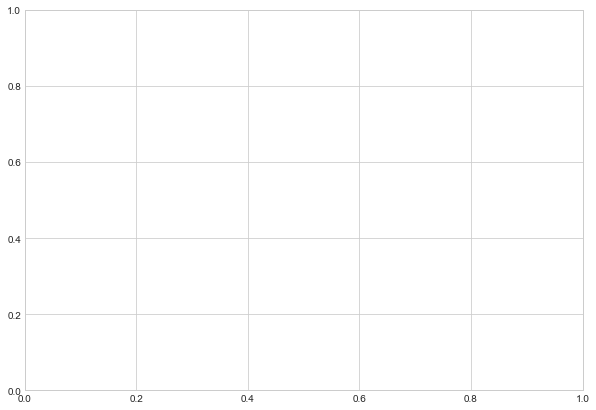

In [61]:
fig, ax = plt.subplots(figsize=(10,7))
df1 = df_combined.pivot_table(index='product', columns='signal', values='ave_yearly_return', aggfunc=np.mean)
sns.heatmap(df1, annot=True, fmt=".2%", ax=ax, cmap='RdYlGn', vmin=0, vmax=15)

## Conclusion

1. Trend following strategies beat out mean-reversion

2. Moving-ave strategies have 3-4x more trades that range_bo

3.  The purpose of this exploratory analysis was to find technical indicators that consistently predict future price movements well.  I believe that has been accomplished and in going forward to create a trading system, this analysis has provided a good foundation for what type of strategies to include.

## Improvement and Future Research Ideas

1. Create actual event-driven trade entry and exits

2. Introduce and optimize risk and target levels

3. Refine timeframes, do these results hold true intraday and longer-term as well

4. Money management - find actual dollar per tick information per product and normalize this research to dollars per trade, or better, percent of overall trading capital

5. Look into potential filters for signals, are there clear times to not take certain strategies based on direction, volatility, seasonality, upcoming announcements/reports